In [0]:
import torch

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2020-05-22 15:32:07--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.13.67, 13.224.13.39, 13.224.13.62, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.13.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  14.6MB/s    in 3.1s    

2020-05-22 15:32:10 (14.6 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/tr

In [0]:
# Data augmentation and normalization for training
# normalization for validation
# transforms.RandomsizedCrop(224) --> A crop of random size (default: of 0.08 to 1.0) of the original size and a
# random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made.
# This crop is finally resized to given size (224 in this case)
# transforms.CenterCrop(224) --> Crops the image at the center. 224 is the Desired output size of the crop.
# torchvision.transforms.Normalize(mean, std)
# input[channel] = (input[channel] - mean[channel]) / std[channel]
data_transforms = {
    'train' : transforms.Compose([
              transforms.RandomResizedCrop(224),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes


print(f'Class Names: {class_names}')
print(f'There are {len(dataloaders["train"])} batches in the training set')
print(f'There are {len(dataloaders["val"])} batches in the test set')
print(f'There are {dataset_sizes["train"]} training images')
print(f'There are {dataset_sizes["val"]} testing images')

Class Names: ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the test set
There are 244 training images
There are 153 testing images


In [7]:
61*4

244

In [8]:
# Load the Pretrained ResNet

model_conv = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# Freeze all layers in the network
for param in model_conv.parameters():
  param.requires_grad = False

In [10]:
model_conv.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [0]:
# Get the number of the last layer (or number of neurons in the layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features

# Reconstruct the last layer (output_layer) to have only two classes
model_conv.fc = nn.Linear(num_ftrs, 2)

In [0]:
if torch.cuda.is_available():
  model_conv = model_conv.cuda()

In [13]:
# Understanding what's happening
iteration = 0
correct = 0

for inputs, labels in dataloaders['train']:
  if iteration == 1:
    break
  inputs = Variable(inputs)
  labels = Variable(labels)

  if torch.cuda.is_available():
    inputs = inputs.cuda()
    labels = labels.cuda()

  print('For one iteration, this is what happens: ')
  print(f'Input Shape: {inputs.shape}')
  print(f'Labels Shape: {labels.shape}')
  print(f'Labels are: {labels}')
  output = model_conv(inputs)
  print(f'Output Tensor: {output}')
  print(f'Outputs Shape {output.shape}')
  _, predicted = torch.max(output, 1)
  print(f'Predicted: {predicted}')
  print(f'Predicted Shape {predicted.shape}')
  correct += (predicted == labels).sum()
  print(f'Correct Predictions: {correct}')

  iteration += 1

For one iteration, this is what happens: 
Input Shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are: tensor([1, 0, 0, 0], device='cuda:0')
Output Tensor: tensor([[ 0.3531, -0.2897],
        [ 0.1921, -0.7123],
        [ 0.7021,  0.2955],
        [-0.0756,  0.3043]], device='cuda:0', grad_fn=<AddmmBackward>)
Outputs Shape torch.Size([4, 2])
Predicted: tensor([0, 0, 0, 1], device='cuda:0')
Predicted Shape torch.Size([4])
Correct Predictions: 2


In [0]:
criterion = nn.CrossEntropyLoss()

# model_conv.fc.parameters() cause we are optimizing the last fully connected layer
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
num_epochs = 25

for epoch in range(num_epochs):
  exp_lr_scheduler.step()
  # Reset the correct to 0 after passing through all the dataset
  correct = 0
  for images, labels in dataloaders['train']:
    images = Variable(images)
    labels = Variable(labels)
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    
    optimizer.zero_grad()
    outputs = model_conv.forward(images)
    loss = criterion(outputs, labels)
    loss.backward() # performing backpropagation
    optimizer.step() # updating the weights
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()

  train_acc = 100 * correct / dataset_sizes['train']
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc}')

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch [1/25], Loss: 2.6661, Train Accuracy: 62
Epoch [2/25], Loss: 0.5881, Train Accuracy: 82
Epoch [3/25], Loss: 0.5525, Train Accuracy: 75
Epoch [4/25], Loss: 0.0510, Train Accuracy: 81
Epoch [5/25], Loss: 0.2121, Train Accuracy: 79
Epoch [6/25], Loss: 0.0078, Train Accuracy: 80
Epoch [7/25], Loss: 0.0655, Train Accuracy: 83
Epoch [8/25], Loss: 0.0718, Train Accuracy: 85
Epoch [9/25], Loss: 0.2597, Train Accuracy: 83
Epoch [10/25], Loss: 0.3318, Train Accuracy: 83
Epoch [11/25], Loss: 0.4113, Train Accuracy: 85
Epoch [12/25], Loss: 0.1440, Train Accuracy: 82
Epoch [13/25], Loss: 0.2924, Train Accuracy: 85
Epoch [14/25], Loss: 0.0488, Train Accuracy: 78
Epoch [15/25], Loss: 0.4637, Train Accuracy: 87
Epoch [16/25], Loss: 0.1282, Train Accuracy: 81
Epoch [17/25], Loss: 0.2955, Train Accuracy: 84
Epoch [18/25], Loss: 0.1582, Train Accuracy: 88
Epoch [19/25], Loss: 0.2924, Train Accuracy: 85
Epoch [20/25], Loss: 1.4024, Train Accuracy: 79
Epoch [21/25], Loss: 0.1119, Train Accuracy: 86
E

In [16]:
 # Test the model
 # Tell pytorch that we want to evaulate our convolution model
 model_conv.eval()

 with torch.no_grad():

   correct = 0
   total = 0

   for (images, labels) in dataloaders['val']:
     images = Variable(images)
     labels = Variable(labels)

     if torch.cuda.is_available():
       images = images.cuda()
       labels = labels.cuda()
      
     outputs = model_conv.forward(images)
     _, predicted = torch.max(outputs.data, 1)
     total += labels.size(0)
     correct += (labels == predicted).sum()

   print(f'Test Accuracy: {100*correct/total:.3f}')

Test Accuracy: 93.000


In [0]:
import matplotlib.pyplot as plt

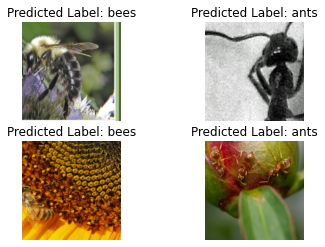

In [21]:
# Visualize some predictions

fig = plt.figure()
shown_batch = 0
index = 0

with torch.no_grad():
  for (images, labels) in dataloaders['train']:
    if shown_batch == 1:
      break
    shown_batch += 1
    images = Variable(images)
    labels = Variable(labels)

    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    
    outputs = model_conv.forward(images)  # The output is of shape (4, 2)
    _, preds = torch.max(outputs, 1)      # The pred is of shape (4) --> [0, 0, 0, 1]

    for i in range(4):
      index += 1
      ax = plt.subplot(2,2, index)
      ax.axis('off')
      ax.set_title(f'Predicted Label: {class_names[preds[i]]}')
      input_img = images.cpu().data[i]  # Get the tensor of the image, and put it to cpu
      inp = input_img.numpy().transpose((1, 2, 0))  # If we have a tensor of shape (2, 3, 4) --> it becomes (3, 4, 2)
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)